# Training Quantum Boltzmann Machines with the quantum relative entropy

We train the parameters of a Quantum Boltzmann Machine by minimizing the quantum relative entropy between the Gibbs state $\rho_{\theta}$ and the target state $\eta$

$$
S\left(\eta \| \rho_\theta\right)=\operatorname{Tr}[\eta \log \eta]-\operatorname{Tr}\left[\eta \log \rho_\theta\right]
$$

Details about computing this quantity and its gradients with respect to the $\theta$ parameters can be found in [this paper](https://dx.doi.org/10.1088/1751-8121/ab7df6) by Kappen.

## Setup

In [1]:
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
rng = np.random.default_rng(seed=1)

In [3]:
# define number of sites == number of qubits (each site is a 2-level system)
n = 6

## Target state

Here we define the target state we want to _learn_ using the QBM model. A target state can be a quantum encoding of some classical dataset, or it can be a real quantum state.

We focus on the case of real quantum states. A way to generate quantum states is by using quantum circuits, as it is done in the [VQE-generated quantum circuit dataset](http://arxiv.org/abs/2302.09751) paper by Nakayama et al.

In `quimb` we can easily define any state (as long as it fits in memory), starting from a given Hamiltonian. As we have seen in the [00_hamiltonians.ipynb](00_hamiltonians.ipynb) notebook, we can use the transverse-field Ising model Hamiltonian and define a thermal state at some temperature.

In [4]:
# Fix the parameters
target_jz = rng.normal()
target_bx = rng.normal()
print(f"Spin interaction used to create target state: {target_jz:.3f}")
print(f"Field valueused to create target state: {target_bx:.3f}")

Spin interaction used to create target state: 0.346
Field valueused to create target state: 0.822


In [5]:
target_tfim = qu.ham_ising(n, target_jz, target_bx)

In [6]:
# fix the temperature of the target state
target_beta = 2.0

Create the thermal state

In [7]:
target_eta = qu.thermal_state(target_tfim, target_beta)

This is the target state we want to learn using a Quantum Boltzmann Machine

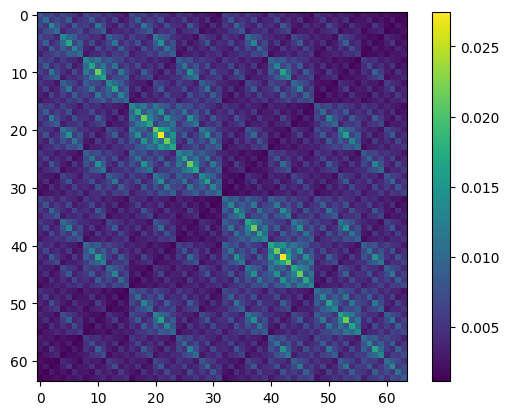

In [8]:
_ = plt.imshow(target_eta, interpolation='nearest')
_ = plt.colorbar()

## QBM definition

Let's start by defining the QBM model we want to use. 
For simplicity we will use a model with the same Hamiltonian that we used to generate the target state above. This is a simplification for demonstration purposes. In general, we could use any arbitrary Hamiltonian, with any number of terms, defined in the same Hilbert space as the target state.

Define the QBM Hamiltonian as the transverse-field Ising model

In [9]:
# parameters to learn. Set initial values
jz = rng.normal()
bx = rng.normal()
print(f"Spin interaction: {jz:.3f}")
print(f"Field value: {bx:.3f}")

Spin interaction: 0.330
Field value: -1.303


In [11]:
qbm_tfim = qu.ham_ising(n, jz, bx)

In [42]:
qbm_tfim

[[0.413046 0.651579 0.651579 ... 0.       0.       0.      ]
 [0.651579 0.247828 0.       ... 0.       0.       0.      ]
 [0.651579 0.       0.082609 ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.082609 0.       0.651579]
 [0.       0.       0.       ... 0.       0.247828 0.651579]
 [0.       0.       0.       ... 0.651579 0.651579 0.413046]]

Look at the initial Gibbs state defined by this Hamiltonian (we set $\beta=1$ because we will learn the parameters in the following and $\beta$ is a simple rescaling that does not affect training.)

In [12]:
rho_qbm = qu.thermal_state(qbm_tfim, 1.0)

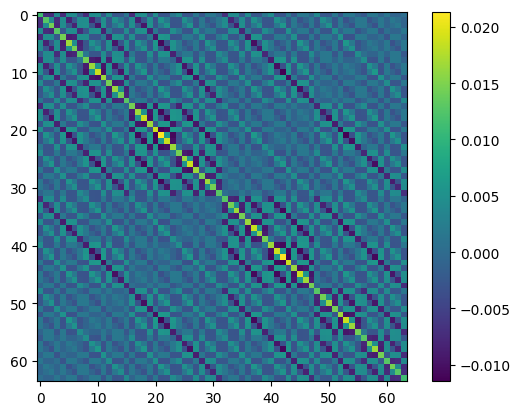

In [13]:
_ = plt.imshow(rho_qbm, interpolation='nearest')
_ = plt.colorbar()

_Roughly speaking_, we would like to make this image look like the target image. We will do so by minimizing the quantum relative entropy, a generalization of the KL divergence from probability distributions to quantum density matrices.

## Quantum relative entropy and its gradients

We repeat here the definition of the relative entropy between a target state $\eta$ and a density matrix (our Gibbs state) $\rho_{\theta}$ parameterized by $\theta$:

$$
S\left(\eta \| \rho_\theta\right)=\operatorname{Tr}[\eta \log \eta]-\operatorname{Tr}\left[\eta \log \rho_\theta\right]
$$

**Note** the first terms is the negative von Neumann entropy of $\eta$: $h(\eta) = -\operatorname{Tr}[\eta \log \eta]$

The QBM learning amounts to minimizing $S\left(\eta \| \rho_\theta\right)$, or maximizing the quantum likelihood 

$$
L(\rho) = \operatorname{Tr}\left[\eta \log \rho_\theta\right] = \operatorname{Tr}\left[\eta H_\theta\right] - \log{Z} = \langle H_{\theta} \rangle_{\eta} - \log{Z}
$$

since $h(\eta)$ does not depend on 

$$
\rho_{\theta} = \frac{e^{\mathcal{H}_\theta}}{Z}
$$

In [16]:
# function to compute the quantum relative entropy between the target density and the QBM
def qre(eta, h_qbm):
    """Quantum relative entropy

    Args:
        eta (Any): Target density matrix
        h_qbm (Any): Hamiltonian of the QBM
    """
    h = qu.entropy(eta)
    evals = qu.eigvalsh(h_qbm)
    z = np.sum(np.exp(evals))
    eta_stat = qu.expec(eta, h_qbm)
    return -h-eta_stat-qu.log2(z)


In [17]:
qre(target_eta, qbm_tfim)

-14.116495864514288

### Gradients

The gradients of the relative entropy w.r.t. the parameters can be written coincisely as

$$
\frac{\partial S\left(\eta \| \rho_\theta\right)}{\partial \theta_i}=\left\langle H_i\right\rangle_{\rho_\theta}-\left\langle H_i\right\rangle_\eta
$$

where $H_i$ are the terms of the QBM Hamiltonian that multiply each of the $\theta_i$ parameters.

In our case we have 2 parameters, and therefore 2 terms $H_i$. They are

$$
H_0 = \sum_{\langle i, j\rangle}  Z_i Z_j
$$

and 

$$
H_1 = \sum_j X_j
$$

In [19]:
# function to create h0 for the TFIM: this is the two-site term
def h_two_sites(n):
    dims = (2,) * n
    two_site_term = qu.kron(qu.spin_operator('z'), qu.spin_operator('z'))
    def gen_term(i):
        return qu.ikron(two_site_term, dims, [i, i + 1])
    return sum(map(gen_term, range(0,n-1)))


In [27]:
h0 = h_two_sites(n)

In [30]:
h0

[[1.25+0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.75+0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.25+0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
 ...
 [0.  +0.j 0.  +0.j 0.  +0.j ... 0.25+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.75+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 1.25+0.j]]

In [28]:
# function to create h1 for the TFIM: this is the transverse-fiels term
def h_single_site(n):
    dims = (2,) * n
    single_site_term = qu.spin_operator('x')
    def gen_term(i):
        return qu.ikron(single_site_term, dims, [i])
    return sum(map(gen_term, range(0,n)))

In [29]:
h1 = h_single_site(n)

In [31]:
h1

[[0. +0.j 0.5+0.j 0.5+0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 ...
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0.5+0.j 0.5+0.j 0. +0.j]]

In [44]:
# test: we should retrive the same TFIM by combining these operators with the parameters
h = jz * h0 - bx * h1

In [45]:
np.allclose(qbm_tfim,h)

True

It is now straighforward to compute the expectation values needed for the gradients

$$
\left\langle H_i\right\rangle_{\rho_\theta}
$$
and
$$
\left\langle H_i\right\rangle_\eta
$$

In [32]:
h0_rho = qu.expec(rho_qbm, h0)
h0_eta = qu.expec(target_eta, h0)


In [33]:
h1_rho = qu.expec(rho_qbm, h1)
h1_eta = qu.expec(target_eta, h1)

In [34]:
gradients = [h0_rho-h0_eta, h1_rho-h1_eta]
print(f"Gradients: {gradients}")

Gradients: [0.06703300668949735, -3.721521569161488]


## Training of the QBM

The last ingredient we need for training the QBM is to use Stochastic Gradient Descent (in this case it is actually exact gradient descent 😄 since the expectation values for the gradients are computed exactly on this small system).

Let us define a learning rate $\gamma$ and a number of epochs (steps):

In [35]:
# learning rate
gamma = 0.2
# number of epochs
epochs = 200

And define a function that computes the gradients and updates the parameters:

In [37]:
def compute_grads(hi, eta, rho):
    """Compute gradients given a list of hamiltonian terms (operators)

    Args:
        hi (List, Tuple): A list of hamiltonian terms
        eta (Any): The target density matrix
        rho (Any): The QBM density matrix

    Returns:
        np.ndarray: The array of the gradients
    """
    grads = []
    for h in hi:
        rho_expect = qu.expec(rho,h)
        eta_expect = qu.expec(eta,h)
        grads.append(rho_expect-eta_expect)
    return np.array(grads)


In [38]:
# test: should match the quantities we got in the previous section!
print(f"Gradients: {compute_grads([h0,h1], target_eta, rho_qbm)}")

Gradients: [ 0.06703301 -3.72152157]


In [39]:
def update_params(params, grads, gamma):
    return params - gamma * grads
    

Here is a single epoch:

    rho_qbm = qbm_H.to_gibbs_state(beta)
    qbm_exp = get_stats(rho_qbm)
    grad = np.array(target_exp) - np.array(qbm_exp)
    print('Max error in stats is {}'.format(np.max(np.abs(grad))))
    stats_error.append(np.abs(grad))
    
    qbm_H.update_params(qbm_grad_step(grad, [qbm_H._fields, qbm_H._interactions], alpha))
    new_loss = boltzmann_relative_entropy(rho_target, qbm_H, beta, pure_target)

In [ ]:
# initialize the QBM parameters (2 in our case)
rho = 